In [ ]:
# Setup (run once)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Import preprocessing method
from preprocessing import preprocess

In [3]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 10
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [4]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [5]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [6]:
# Load pre-trained word embeddings
path_to_glove_file =  "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
# Embedding Matrix
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in pre-trained embeddings will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 63711 words (84568 misses)


In [8]:
# Define CNN model
model = Sequential()
model.add(Embedding(num_words, ENCODED_VECTOR_SIZE, embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
model.add(Conv1D(BATCH_SIZE, 5, activation="relu"))
model.add(MaxPooling1D(3))
model.add(Conv1D(BATCH_SIZE, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         44484000  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 20)                2

In [9]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
106/106 [==============================] - 45s 423ms/step - loss: 1.8859 - accuracy: 0.4193 - val_loss: 1.1912 - val_accuracy: 0.6240
Epoch 2/10
106/106 [==============================] - 37s 353ms/step - loss: 0.9162 - accuracy: 0.7193 - val_loss: 1.0364 - val_accuracy: 0.6684
Epoch 3/10
106/106 [==============================] - 32s 298ms/step - loss: 0.6447 - accuracy: 0.8133 - val_loss: 0.9386 - val_accuracy: 0.7162
Epoch 4/10
106/106 [==============================] - 33s 313ms/step - loss: 0.4564 - accuracy: 0.8796 - val_loss: 0.9047 - val_accuracy: 0.7255
Epoch 5/10
106/106 [==============================] - 35s 328ms/step - loss: 0.3249 - accuracy: 0.9197 - val_loss: 0.8878 - val_accuracy: 0.7401
Epoch 6/10
106/106 [==============================] - 31s 295ms/step - loss: 0.2150 - accuracy: 0.9585 - val_loss: 0.8897 - val_accuracy: 0.7387
Epoch 7/10
106/106 [==============================] - 35s 326ms/step - loss: 0.1389 - accuracy: 0.9805 - val_loss: 0.8980 - val_ac

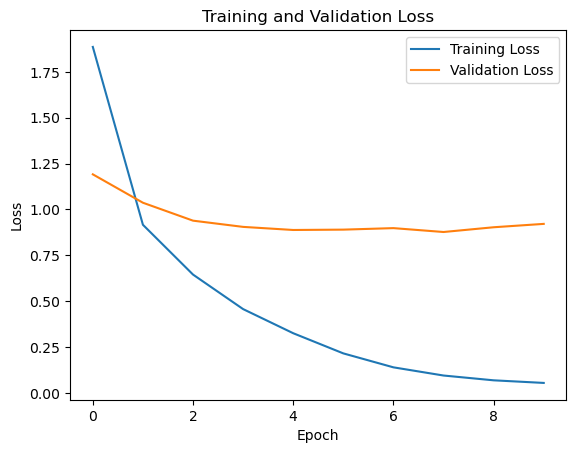

In [10]:
# Plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

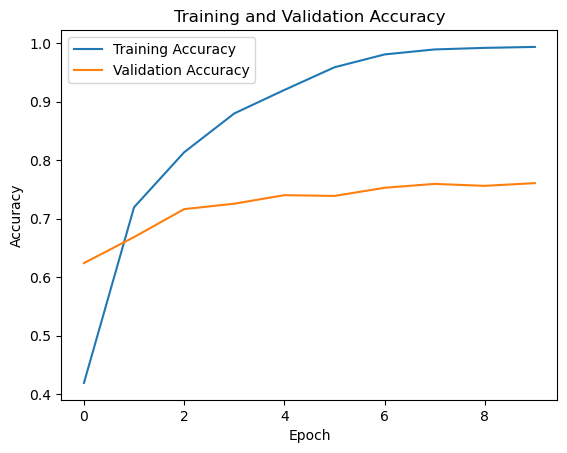

In [11]:
# Plot accuracy curves
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 2s 16ms/step
Accuracy: 0.7777188328912467


In [13]:
# Model comparison
